# 4chan Data Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import psycopg2
import csv

from dotenv import load_dotenv
load_dotenv()

import os


In [4]:

FAKTORY_SERVER_URL = os.environ.get("FAKTORY_SERVER_URL")
DATABASE_URL = os.environ.get("DATABASE_URL")

## Posts per day

In [5]:
# Function to fetch data
def fetch_posts_per_day(DATABASE_URL):
    try:
        # Create the connection string
        conn = psycopg2.connect(dsn=DATABASE_URL)
        # Query data from the table
        query = """
        SELECT 
            to_timestamp((data->>'time')::BIGINT) :: DATE AS post_date,
            COUNT(*) AS post_count
        FROM 
            posts
        GROUP BY 
            post_date
        ORDER BY 
            post_date;
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [6]:
def plot_posts_per_day(df):
    try:
        plt.figure(figsize=(14, 8))
        plt.plot(df['post_date'], df['post_count'], marker='o', linestyle='-', color='b')
        plt.title("Number of Posts Collected Per Day", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Number of Posts", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting data: {e}")

### Fig 1: Posts per day

/tmp/ipykernel_1458706/3753823629.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


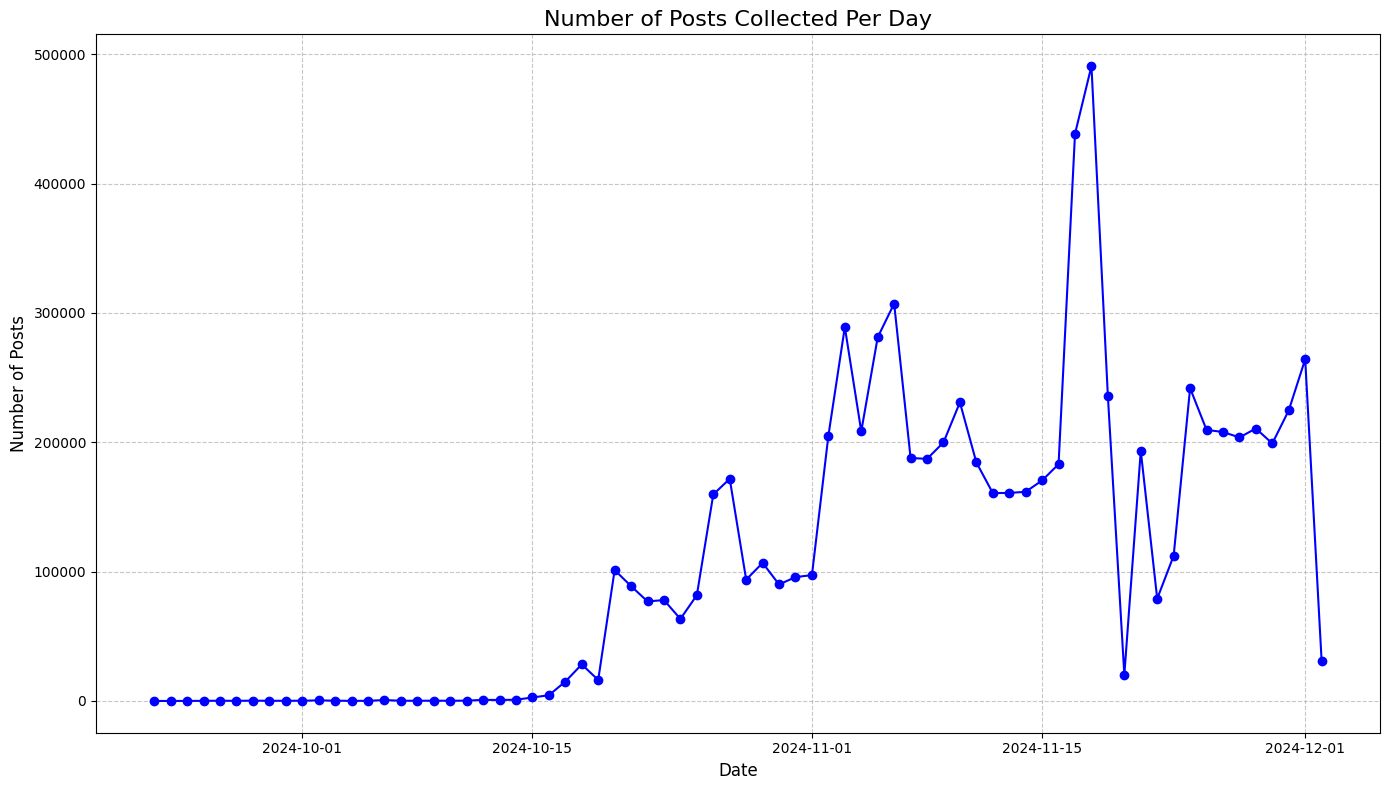

In [7]:
df = fetch_posts_per_day(DATABASE_URL)
if df is not None:
    plot_posts_per_day(df)

## Posts per board

In [8]:
def fetch_posts_per_board(DATABASE_URL):
    try:
        # Create the connection string
        conn = psycopg2.connect(dsn=DATABASE_URL)
        # Query data from the table
        query = """
        SELECT board, count(*) from posts group by board;
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [9]:
df = fetch_posts_per_board(DATABASE_URL)


/tmp/ipykernel_1458706/3269653318.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [10]:
print(df.head())

d = dict(df)
print(d.keys())
print(d.values())

  board    count
0   pol  4816427
1    sp  3041696
dict_keys(['board', 'count'])
dict_values([0    pol
1     sp
Name: board, dtype: object, 0    4816427
1    3041696
Name: count, dtype: int64])


In [11]:
def plot_posts_per_board(df):
    try:
        plt.figure(figsize=(10, 6))
        plt.bar(df['board'], df['count'],  color=['skyblue', 'orange'])
        plt.title("Posts Count Per Board", fontsize=16)
        plt.xlabel("Board", fontsize=12)
        plt.ylabel("Posts Count", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting histogram: {e}")

### Fig 2: Posts per board

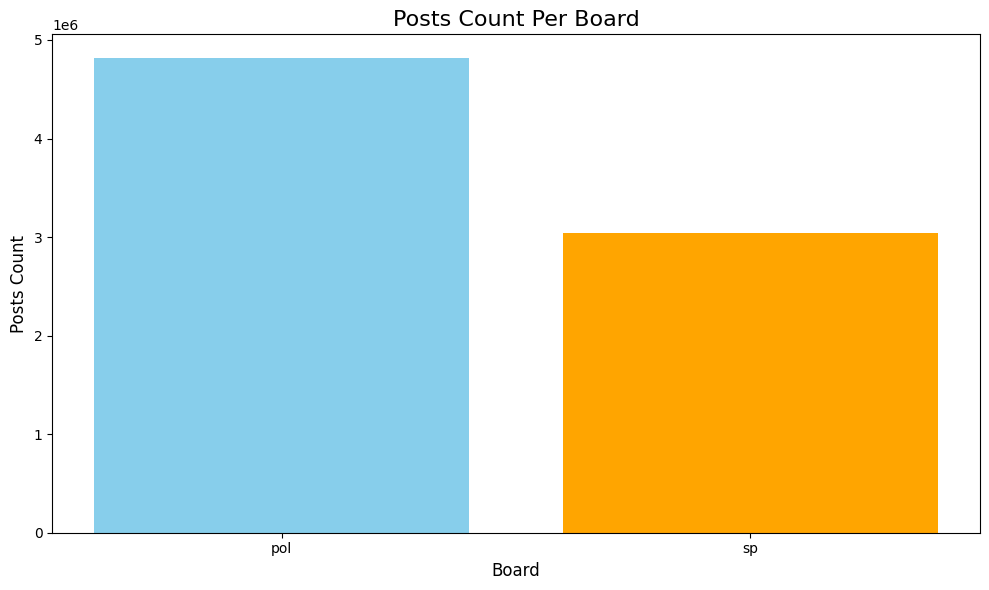

In [12]:
plot_posts_per_board(df)

In [51]:
def fetch_data_from_db(query):
    """
    Execute a query and return the result as a DataFrame.
    
    Args:
        query (str): SQL query to execute.
        conn_params (dict): Connection parameters for PostgreSQL.
    
    Returns:
        pd.DataFrame: Query results as a DataFrame.
    """
    try:
        # Establish the connection
        conn = psycopg2.connect(dsn=DATABASE_URL)
        # Execute the query
        df = pd.read_sql_query(query, conn)
        # Close the connection
        conn.close()
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None
    

def plot_avg_toxic_scores(non_toxic_df, toxic_df, title):
    """
    Plot average non-toxic and toxic scores by date.
    
    Args:
        non_toxic_df (pd.DataFrame): DataFrame with non-toxic scores.
        toxic_df (pd.DataFrame): DataFrame with toxic scores.
    """
    plt.figure(figsize=(12, 6))

    # Plot non-toxic scores
    plt.plot(non_toxic_df['date'], non_toxic_df['avg_non_toxic_score'], label='Non-Toxic Score', color='blue', marker='o')
    # Plot toxic scores
    plt.plot(toxic_df['date'], toxic_df['average_toxic_score'], label='Toxic Score', color='red', marker='o')

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Average Score", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Posts per hour

In [45]:
query_posts_per_hr = """
SELECT 
    DATE_TRUNC('hour', to_timestamp((data->>'time')::BIGINT)) AS hour,
    COUNT(*) AS post_count
FROM posts
WHERE 
    to_timestamp((data->>'time')::BIGINT) BETWEEN '2024-11-01 00:00:00' AND '2024-11-14 23:59:59'
    AND board = 'pol'
GROUP BY hour
ORDER BY hour;
"""

In [46]:
posts_per_hr_df = fetch_data_from_db(query_posts_per_hr)

/tmp/ipykernel_1458706/2032542993.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [47]:
posts_per_hr_df.head()

,hour,post_count
0,2024-11-01 09:00:00+00:00,7
1,2024-11-01 10:00:00+00:00,54
2,2024-11-01 11:00:00+00:00,94
3,2024-11-01 12:00:00+00:00,42
4,2024-11-01 13:00:00+00:00,54


In [48]:
def plot_posts_per_hour(posts_per_hr_df, title, x_label, y_label):
    """
    Plot the number of posts per hour over 14 days.

    Args:
        posts_per_hr_df (pd.DataFrame): DataFrame containing 'hour' and 'post_count' columns.
    """
    # Ensure 'hour' is in datetime format
    posts_per_hr_df['hour'] = pd.to_datetime(posts_per_hr_df['hour'])
    
    # Plot the data
    plt.figure(figsize=(14, 8))
    plt.plot(posts_per_hr_df['hour'], posts_per_hr_df['post_count'], color='blue', linewidth=2, marker='o', markersize=4)
    
    # Formatting x-axis for hourly intervals
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks for each day
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.xticks(rotation=45, fontsize=10)
    
    # Adding titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    # Adding grid for better readability
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Fig: Posts per hr

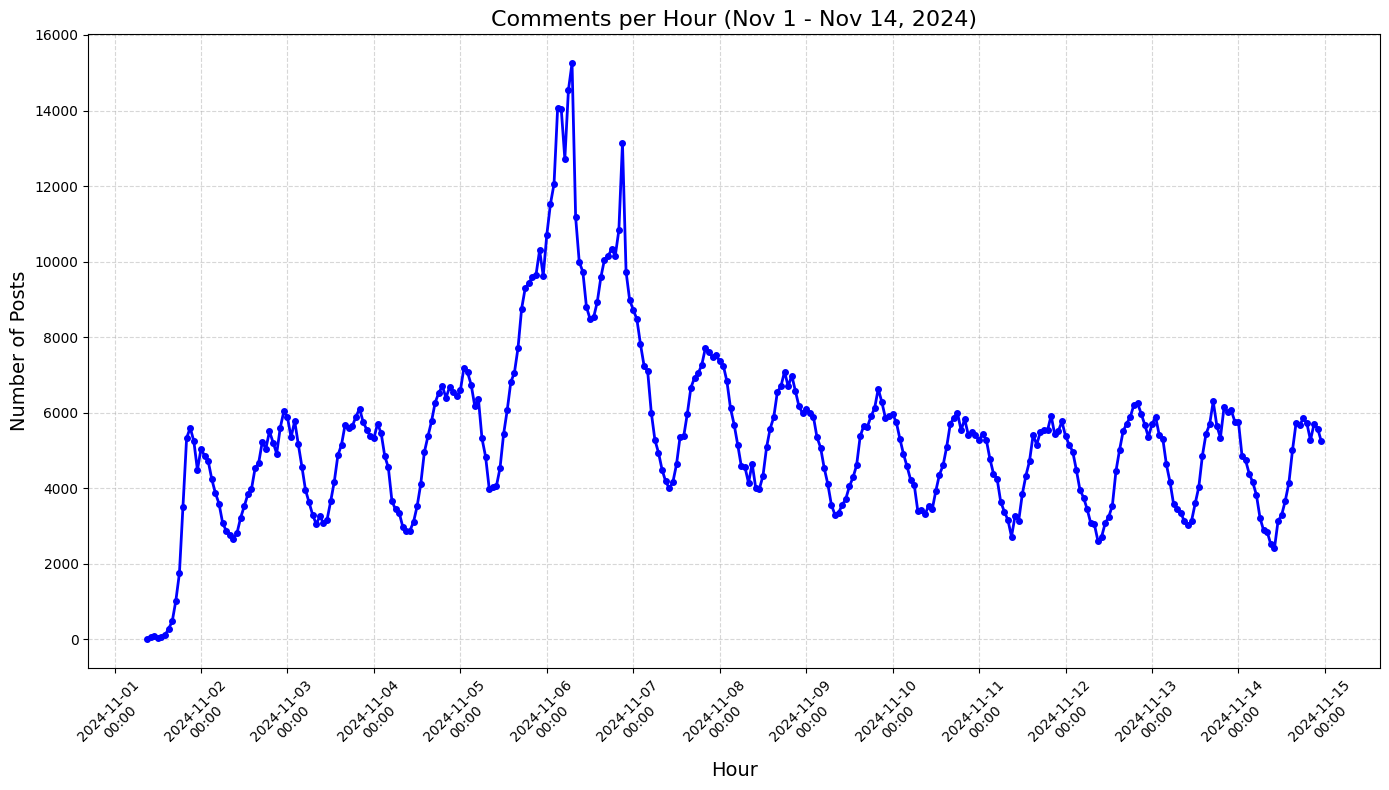

In [50]:
# Assuming the DataFrame is named posts_per_hr_df
plot_posts_per_hour(posts_per_hr_df, title = "Comments per Hour (Nov 1 - Nov 14, 2024)", x_label="Hour", y_label="Number of Posts")

## Toxic and Non toxic scores for /pol

In [53]:
query_non_toxic = """
SELECT 
    to_timestamp((data->>'time')::BIGINT) :: DATE AS date,
    AVG(toxic_score) AS avg_non_toxic_score
FROM 
    posts
WHERE 
    toxic_class != 'flag' and board = 'pol'
GROUP BY 
    date
ORDER BY 
    date;
"""

query_toxic = """
SELECT 
    to_timestamp((data->>'time')::BIGINT) :: DATE AS date,
    AVG(toxic_score) AS average_toxic_score
FROM 
    posts
WHERE 
    toxic_class = 'flag' and board = 'pol'
GROUP BY 
    date
ORDER BY 
    date;
"""

# Fetch data
non_toxic_df = fetch_data_from_db(query_non_toxic)
toxic_df = fetch_data_from_db(query_toxic)


/tmp/ipykernel_1458706/3003459313.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Fig 3: Toxic and Non toxic scores for /pol

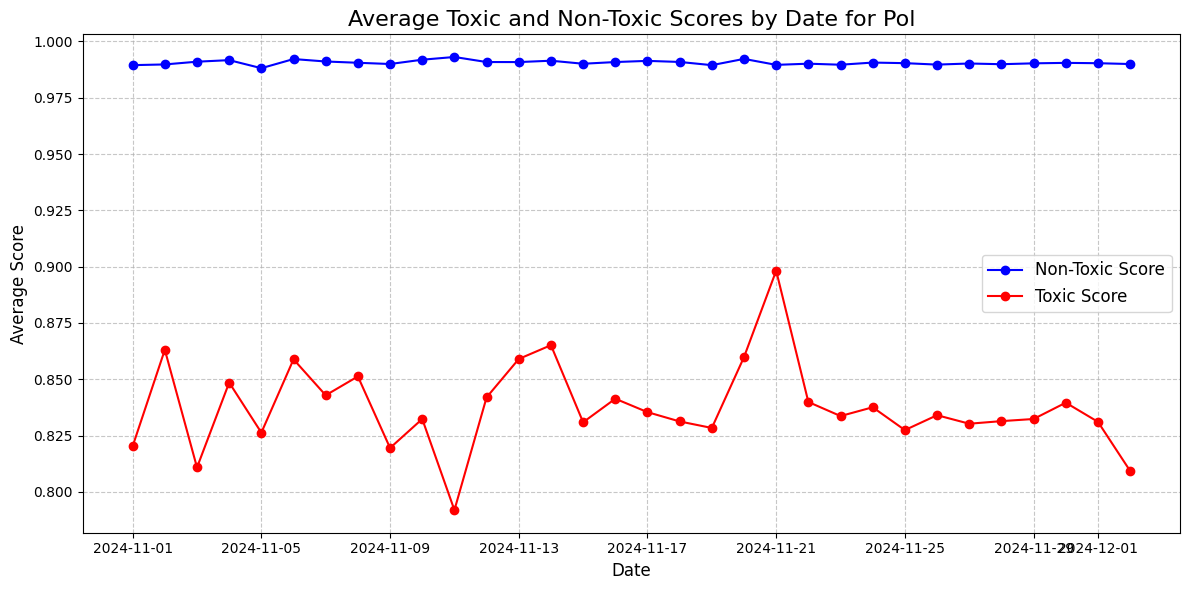

In [54]:
# Plot the data
if non_toxic_df is not None and toxic_df is not None:
    plot_avg_toxic_scores(non_toxic_df, toxic_df, "Average Toxic and Non-Toxic Scores by Date for Pol")

## Toxic vs Non toxic scores for /sp

In [59]:
query_non_toxic = """
SELECT 
    to_timestamp((data->>'time')::BIGINT) :: DATE AS date,
    AVG(toxic_score) AS avg_non_toxic_score
FROM 
    posts
WHERE 
    toxic_class != 'flag' and board = 'sp'
GROUP BY 
    date
ORDER BY 
    date;
"""

query_toxic = """
SELECT 
    to_timestamp((data->>'time')::BIGINT) :: DATE AS date,
    AVG(toxic_score) AS average_toxic_score
FROM 
    posts
WHERE 
    toxic_class = 'flag' and board = 'sp'
GROUP BY 
    date
ORDER BY 
    date;
"""

# Fetch data
non_toxic_df = fetch_data_from_db(query_non_toxic)
toxic_df = fetch_data_from_db(query_toxic)


/tmp/ipykernel_1458706/3003459313.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Fig 4: Toxic vs Non toxic scores for /sp

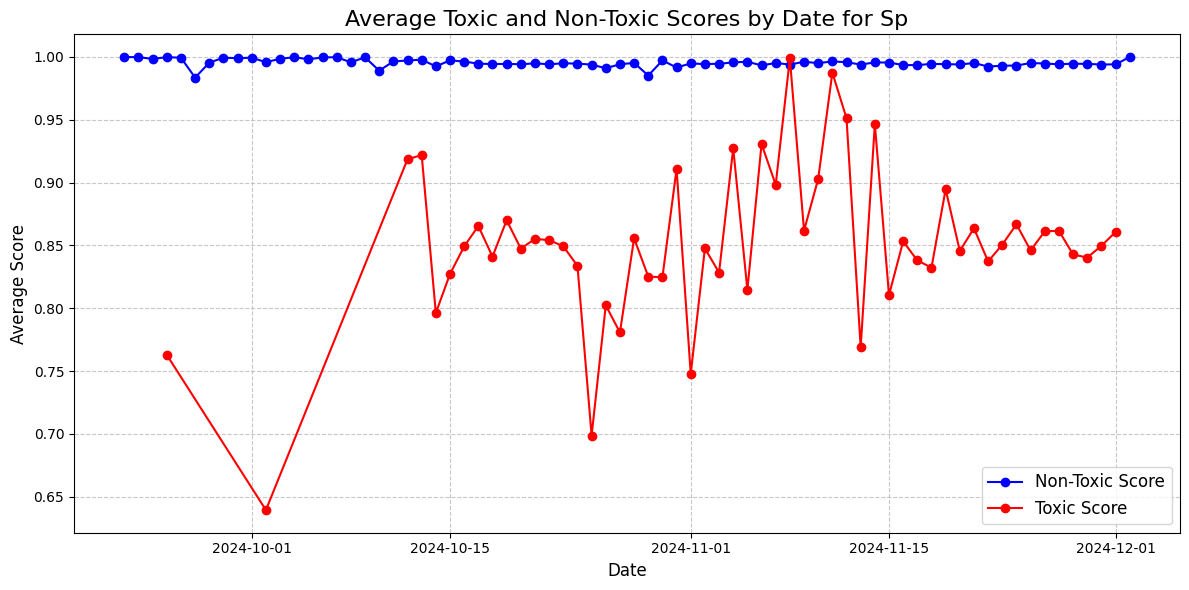

In [60]:
# Plot the data
if non_toxic_df is not None and toxic_df is not None:
    plot_avg_toxic_scores(non_toxic_df, toxic_df, "Average Toxic and Non-Toxic Scores by Date for Sp")

## Posts per day by toxicity class

In [61]:
query_flag_vs_normal = """
SELECT 
    to_timestamp((data->>'time')::BIGINT) :: DATE AS date,
    toxic_class,
    COUNT(*) AS count
FROM 
    posts
WHERE 
    toxic_class IN ('flag', 'normal') 
    AND to_timestamp((data->>'time')::BIGINT) :: DATE BETWEEN '2024-10-15' AND '2024-12-30'
GROUP BY 
    date, toxic_class
ORDER BY 
    date, toxic_class;

"""

In [62]:
def plot_overlay_bar_chart(df):
    """
    Plot an overlay bar chart with dates on x-axis and number of posts on y-axis.

    Args:
        df (pd.DataFrame): DataFrame with columns ['date', 'toxic_class', 'count'].
    """
    # Pivot the data to create separate columns for each toxic_class
    pivot_df = df.pivot(index='date', columns='toxic_class', values='count').fillna(0)

    # Plot the overlay bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(pivot_df.index, pivot_df['flag'], label='Toxic (flag)', color='red', alpha=0.7)
    plt.bar(pivot_df.index, pivot_df['normal'], label='Normal', color='green', alpha=0.7, bottom=pivot_df['flag'])

    plt.title("Number of Posts per Day by Toxicity Class", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of Posts", fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [63]:
flag_vs_normal_df = fetch_data_from_db(query_flag_vs_normal)

/tmp/ipykernel_1458706/3003459313.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [64]:
flag_vs_normal_df.head()

,date,toxic_class,count
0,2024-10-15,flag,13
1,2024-10-15,normal,2331
2,2024-10-16,flag,53
3,2024-10-16,normal,3645
4,2024-10-17,flag,177


### Fig 5: Posts per day by toxicity class

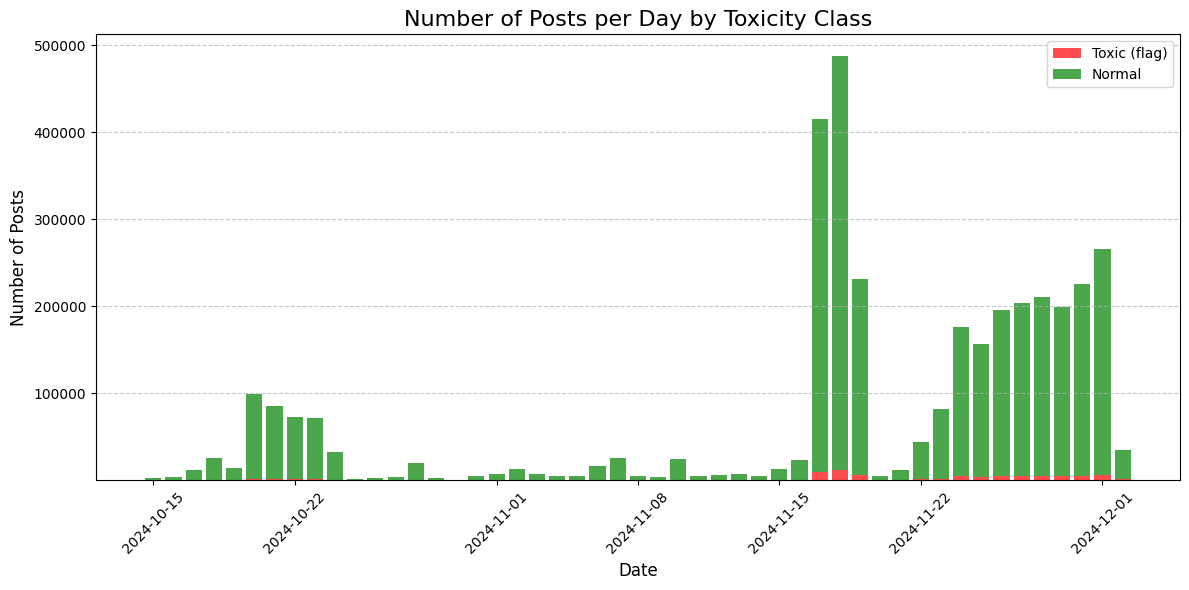

In [65]:
if flag_vs_normal_df is not None:
    # Plot the overlay bar chart
    plot_overlay_bar_chart(flag_vs_normal_df)

## Engagement score vs toxicity

In [66]:
query_engagement_vs_toxicity = """
select 
    post_number, data->>'replies' as replies_count, toxic_score 
from 
    posts
 where 
    toxic_class='flag' and data->>'replies' is not NULL 
order by 
    data->>'replies' desc 
limit 1000;
"""

In [67]:
query_engagement_vs_toxicity_df = fetch_data_from_db(query_engagement_vs_toxicity)

/tmp/ipykernel_1458706/3003459313.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [68]:
query_engagement_vs_toxicity_df = query_engagement_vs_toxicity_df.sort_values(by=['replies_count','toxic_score'], ascending=[True, False])

In [69]:
query_engagement_vs_toxicity_df.head()

,post_number,replies_count,toxic_score
961,488814398,5,0.999238
966,488814398,5,0.999238
985,489840966,5,0.999213
956,488712582,5,0.998427
957,488712582,5,0.998427


In [70]:
def plot_score_vs_toxicity(data, title, x_axis, y_axis, x_label, y_label):
    """
    Plot a scatter plot for score vs. toxicity_score.

    Args:
        data (pd.DataFrame): DataFrame containing 'score' and 'toxicity_score'.
    """
    plt.figure(figsize=(12, 6))
    
    # Create a scatter plot with a color map
    scatter = plt.scatter(
        data[x_axis], 
        data[y_axis], 
        c=data[y_axis], 
        cmap='cool', 
        s=50, 
        alpha=0.7
    )
    
    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Toxicity Score Intensity', fontsize=12)

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.colorbar(plt.cm.ScalarMappable(cmap='cool'), label='Toxicity Intensity')
    plt.tight_layout()
    plt.show()

### Enagagement(replies) Score vs Toxicity

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

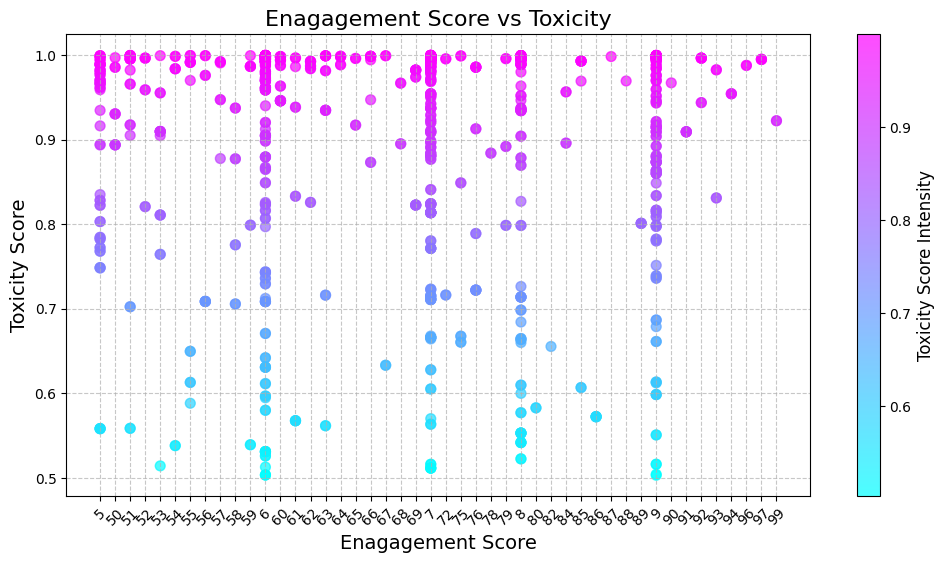

In [71]:
plot_score_vs_toxicity(query_engagement_vs_toxicity_df, title="Enagagement Score vs Toxicity" ,
                       x_axis='replies_count', y_axis='toxic_score',
                       x_label='Enagagement Score', y_label='Toxicity Score')

## Total flag and normal class

In [34]:
query_class_distribution = """
select 
    toxic_class, count(*) 
from 
    posts 
where 
    toxic_class = 'flag' or toxic_class = 'normal'
group by
    toxic_class;
"""

In [35]:
toxic_class_distribution_df = fetch_data_from_db(query_class_distribution)

/tmp/ipykernel_1458706/2032542993.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [36]:
toxic_class_distribution_df.head()

,toxic_class,count
0,flag,79000
1,normal,3479252


In [38]:
def plot_posts_per_class(df):
    try:
        plt.figure(figsize=(10, 6))
        plt.bar(df['toxic_class'], df['count'],  color=['skyblue', 'orange'])
        plt.title("Posts Count Per toxic class", fontsize=16)
        plt.xlabel("Board", fontsize=12)
        plt.ylabel("Posts Count", fontsize=12)
        plt.yscale('log')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting histogram: {e}")

### Fig: Toxic class distribution

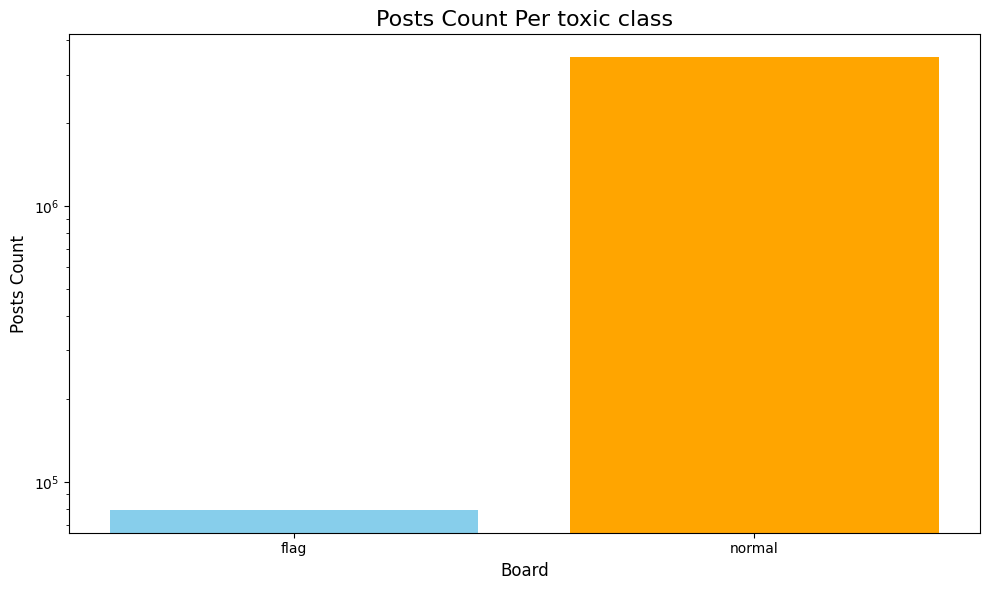

In [39]:
plot_posts_per_class(toxic_class_distribution_df)

## Sentiment analysis

In [40]:
query_sentiment = """
select data->>'com' as comments from posts limit 1000;
"""

In [41]:
comemnts_df = fetch_data_from_db(query_sentiment)

/tmp/ipykernel_1458706/2032542993.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [42]:
comemnts_df.dropna(subset=['comments'], inplace=True)

In [43]:
comemnts_df.head()

,comments
0,"<a href=""#p145542985"" class=""quotelink"">&gt;&g..."
1,"<a href=""#p145573023"" class=""quotelink"">&gt;&g..."
2,se o pedro raul tivesse jogando já tinha marca...
3,Remember when Quilmes used to make great comme...
4,eu acho que é sombrio ver refugo do palmeiras ...


In [44]:
comemnts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 0 to 999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  984 non-null    object
dtypes: object(1)
memory usage: 15.4+ KB


In [ ]:
'''
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import torch
print("PyTorch version:", torch.__version__)  # For PyTorch

# pip install tensorflow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)  # For TensorFlow
'''

'\n# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu\nimport torch\nprint("PyTorch version:", torch.__version__)  # For PyTorch\n\n# pip install tensorflow\nimport tensorflow as tf\nprint("TensorFlow version:", tf.__version__)  # For TensorFlow\n'

In [ ]:
'''
# Testing with sample data
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)
'''

'\n# Testing with sample data\nfrom transformers import pipeline\nsentiment_pipeline = pipeline("sentiment-analysis")\ndata = ["I love you", "I hate you"]\nsentiment_pipeline(data)\n'

In [ ]:
from transformers import pipeline

# Load pre-trained sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Perform sentiment analysis
def analyze_sentiments(comments):
    """
    Analyze sentiment of a list of comments using a Hugging Face sentiment-analysis pipeline.

    Args:
        comments (list): List of text comments.

    Returns:
        pd.DataFrame: DataFrame with sentiment and scores.
    """
    results = sentiment_analyzer(comments)
    return pd.DataFrame(results)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# Analyze sentiments for all comments
sentiment_df = analyze_sentiments(comemnts_df['comments'].tolist())

# Combine sentiment results with original DataFrame
comemnts_df['sentiment'] = sentiment_df['label']
comemnts_df['score'] = sentiment_df['score']

In [ ]:
comemnts_df.head()

,comments,sentiment,score
0,"<a href=""#p488362431"" class=""quotelink"">&gt;&g...",POSITIVE,0.999177
1,"<a href=""#p488363718"" class=""quotelink"">&gt;&g...",NEGATIVE,0.989698
2,Pure silicon and photo lithography,POSITIVE,0.990618
3,"<a href=""#p488362416"" class=""quotelink"">&gt;&g...",POSITIVE,0.996742
4,"<a href=""#p488361817"" class=""quotelink"">&gt;&g...",NEGATIVE,0.992417


### Fig - sentiment analysis using hugging-face distil bert

/tmp/ipykernel_1444257/832724981.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=posts_df, x='sentiment', palette='coolwarm')


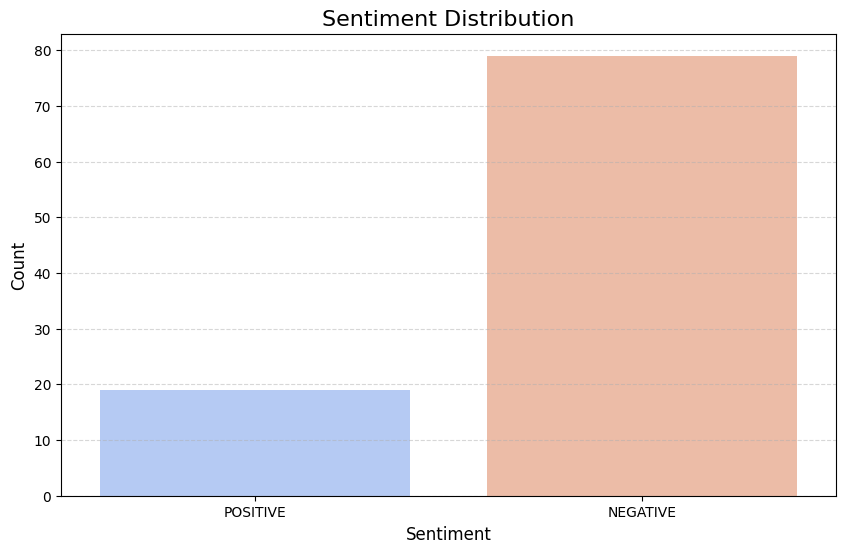

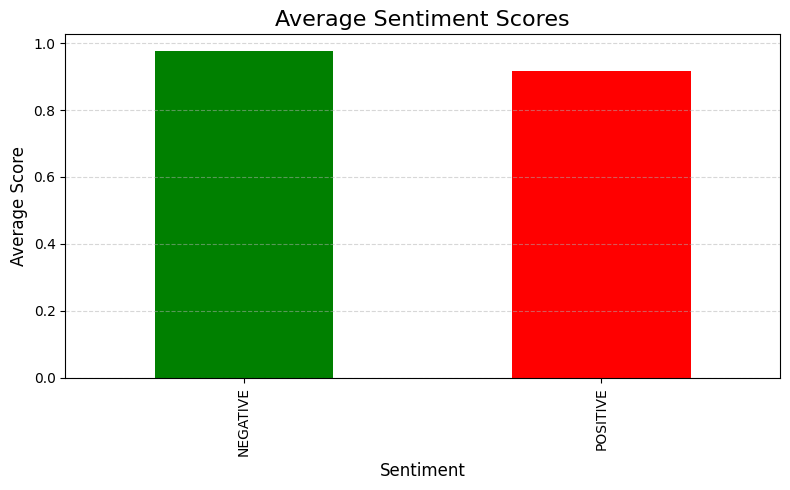

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sentiments(posts_df):
    """
    Plot sentiment distributions and average sentiment scores.

    Args:
        posts_df (pd.DataFrame): DataFrame with 'sentiment' and 'score' columns.
    """
    # Countplot for sentiment distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=posts_df, x='sentiment', palette='coolwarm')
    plt.title("Sentiment Distribution", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    
    # Average sentiment scores by sentiment
    avg_scores = posts_df.groupby('sentiment')['score'].mean()
    avg_scores.plot(kind='bar', figsize=(8, 5), color=['green', 'red'])
    plt.title("Average Sentiment Scores", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Average Score", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_sentiments(comemnts_df)
